## 1º Bloco: Frames Preprocessing:

Implementação do primeiro bloco do pipeline faz o pré-processamento de uma instância de gesto do dataset LynX:

Lê frames .png (um intervalo definido em gesture_segmentation.csv)
Converte cada frame RGB num tensor 2 canais:
- Canal 0 (ON) = canal R
- Canal 1 (OFF) = canal B
- Canal G ignorado

Redimensiona para target_size × target_size com nearest neighbor (preserva valores “tipo evento”)

No fim, devolve:
- frames_seq: lista de frames (2, H, W) em float32
- label: (gesture_type, gesture_name)

In [29]:
from pathlib import Path
from typing import Mapping, List, Tuple, Optional
from skimage.util import view_as_blocks

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

### Função principal: preprocess_lynx_gesture

Esta função recebe:
- row: uma linha do CSV (ex.: pandas.Series)
- dataset_root: pasta base onde estão os subject_X/...
- target_size: tamanho final (default 128)

Faz as Seguintes Etapas:
- Valida start_frame e end_frame
- Monta o caminho correto para a pasta frames
- Para cada frame no intervalo:
   carrega PNG | faz resize | extrai R e B | normaliza para [0, 1] | agrupa em (H, W, 2)
- Devolve a sequência e o label

In [30]:
def preprocess_lynx_gesture(
    row: Mapping,
    dataset_root: str,
    target_size: int = 128,
) -> Tuple[List[np.ndarray], Tuple[int, str]]:
    
    start_frame = int(row["start_frame"])
    end_frame = int(row["end_frame"])

    if end_frame < start_frame:
        raise ValueError(
            f"Invalid frame range: start_frame={start_frame}, end_frame={end_frame}"
        )

    subject = row["subject"]
    scenario = row["scenario"]
    gesture_type = int(row["gesture_type"])
    gesture_name = row["gesture_name"]

    dataset_root = Path(dataset_root)

    frames_dir = (
        dataset_root
        / subject
        / scenario
        / f"gesture_{gesture_type}"
        / "frames"
    )

    frames_seq: List[np.ndarray] = []

    for frame_idx in range(start_frame, end_frame + 1):
        frame_path = frames_dir / f"{frame_idx}.png"

        if not frame_path.exists():
            # Missing frames are skipped silently
            continue

        # Load image as RGB
        img = Image.open(frame_path).convert("RGB")

        # Resize using nearest-neighbor to preserve event-like values
        if img.size != (target_size, target_size):
            img = img.resize((target_size, target_size), Image.NEAREST)

        img_np = np.asarray(img, dtype=np.float32)

        # Extract channels
        # R -> ON, B -> OFF, G ignored
        on_channel = img_np[:, :, 0] / 255.0
        off_channel = img_np[:, :, 2] / 255.0

        # Stack as (H, W, 2), channel-first
        frame = np.stack([on_channel, off_channel], axis=-1).astype(np.float32)  # (H, W, 2)

        frames_seq.append(frame)

    label = (gesture_type, gesture_name)

    return frames_seq, label

### Visualização dos frames originais com ON (R) e OFF (B)

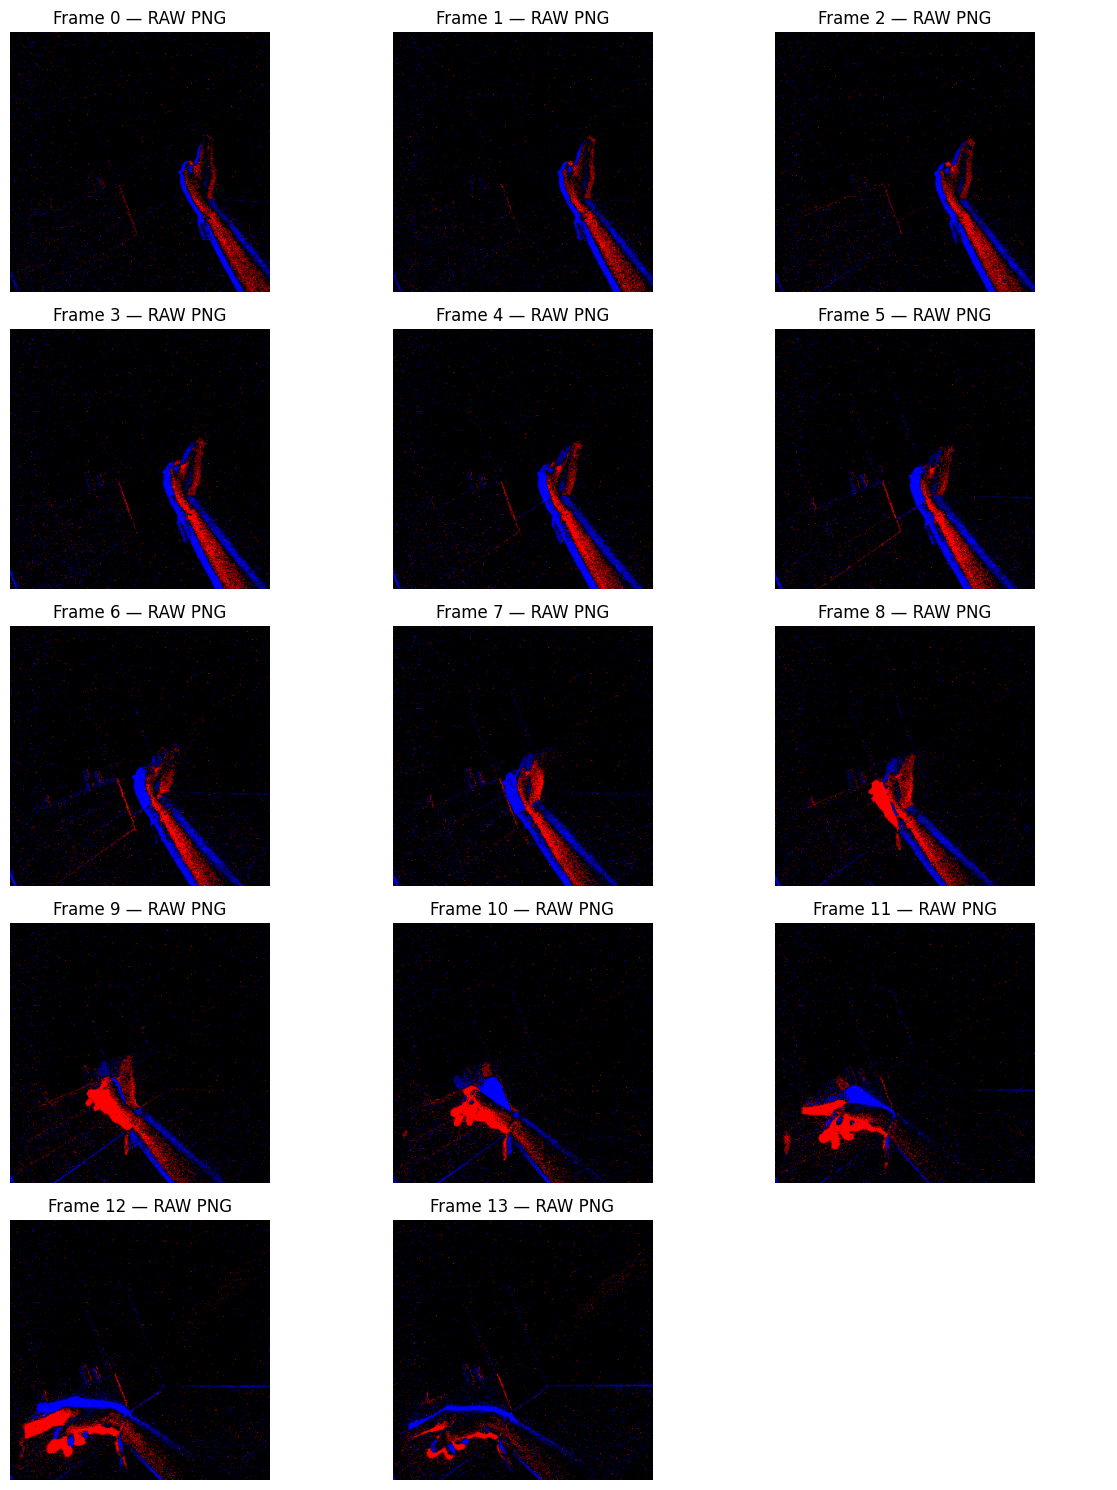

RAW FRAME
dtype: uint8
min: 0
max: 255
Frames: 14
Min (global):  0
Max (global):  255
Mean (avg):    5.07


In [31]:
# -------------------------------
# Visualização dos frames RAW (PNG original)
# -------------------------------
start_frame = int(row["start_frame"])
end_frame   = int(row["end_frame"])

dataset_root = Path("../../../datasets/LynX/data")

frames_dir = (
    dataset_root
    / row["subject"]
    / row["scenario"]
    / f"gesture_{row['gesture_type']}"
    / "frames"
)

raw_frames = []

for frame_idx in range(start_frame, end_frame + 1):
    frame_path = frames_dir / f"{frame_idx}.png"
    if not frame_path.exists():
        continue

    img = Image.open(frame_path).convert("RGB")
    raw = np.asarray(img)   # uint8 [0,255], (H,W,3)
    raw_frames.append(raw)

if len(raw_frames) == 0:
    print("Sem frames RAW para visualizar.")
else:
    n_show = min(len(raw_frames), 14)
    rows, cols = 5, 3

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.reshape(rows, cols)

    for idx in range(rows * cols):
        r, c = divmod(idx, cols)
        ax = axes[r, c]

        if idx < n_show:
            raw = raw_frames[idx]  # (H, W, 3), uint8
            ax.imshow(raw)
            ax.set_title(f"Frame {idx} — RAW PNG")
            ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# -------------------------------
# Sanity-check numérico (RAW)
# -------------------------------
f_raw = raw_frames[0]

print("RAW FRAME")
print("dtype:", f_raw.dtype)
print("min:", f_raw.min())
print("max:", f_raw.max())

# -------------------------------
# Estatísticas globais (RAW)
# -------------------------------
mins = [f.min() for f in raw_frames]
maxs = [f.max() for f in raw_frames]
means = [f.mean() for f in raw_frames]

print(f"Frames: {len(raw_frames)}")
print(f"Min (global):  {min(mins)}")
print(f"Max (global):  {max(maxs)}")
print(f"Mean (avg):    {sum(means)/len(means):.2f}")


### Correr preprocess_lynx_gesture

- Carregar o CSV gesture_segmentation.csv
- Ler a primeira linha
- Vai retornar: número de frames carregados | shape do primeiro frame | min/max do primeiro frame | label do gesto

In [32]:
dataset_root = Path("../../../datasets/LynX/data")
csv_path = Path("../../../datasets/LynX/gesture_segmentation.csv")

if not csv_path.exists():
    raise FileNotFoundError(f"gesture_segmentation.csv not found at: {csv_path}")

df = pd.read_csv(csv_path)

if len(df) == 0:
    raise RuntimeError("gesture_segmentation.csv is empty.")

row = df.iloc[0]

frames_seq, label = preprocess_lynx_gesture(
    row=row,
    dataset_root=str(dataset_root),
    target_size=128,
)

print("=== LynX Preprocessing Self-Check ===")
print(f"Number of frames loaded: {len(frames_seq)}")

if len(frames_seq) > 0:
    first_frame = frames_seq[0]
    print(f"First frame shape: {first_frame.shape}")
    print(f"First frame min/max: {first_frame.min():.3f} / {first_frame.max():.3f}")

print(f"Label (gesture_type, gesture_name): {label}")

=== LynX Preprocessing Self-Check ===
Number of frames loaded: 14
First frame shape: (128, 128, 2)
First frame min/max: 0.000 / 1.000
Label (gesture_type, gesture_name): (1, 'Swipe Left')


### Visualização clara: ver ON/OFF do primeiro frame

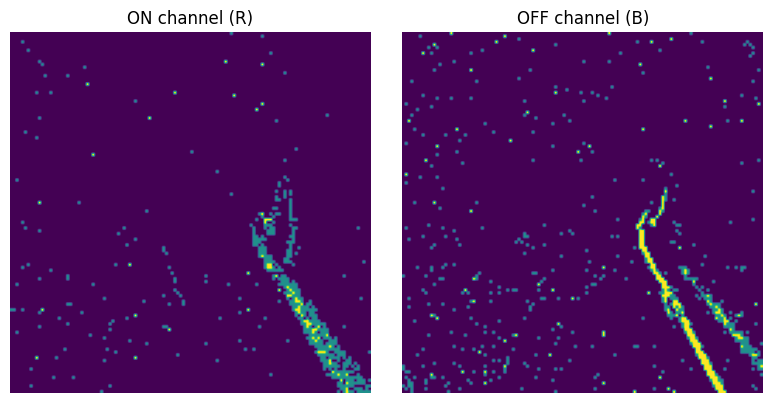

In [33]:
if len(frames_seq) == 0:
    print("Sem frames para visualizar.")
else:
    first = frames_seq[0]   # (H, W, 2)
    on = first[..., 0]      # ON
    off = first[..., 1]     # OFF

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(on, vmin=0, vmax=1)
    axes[0].set_title("ON channel (R)")
    axes[0].axis("off")

    axes[1].imshow(off, vmin=0, vmax=1)
    axes[1].set_title("OFF channel (B)")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

### Visualização dos frames pre-processados com ON (R) e OFF (B)

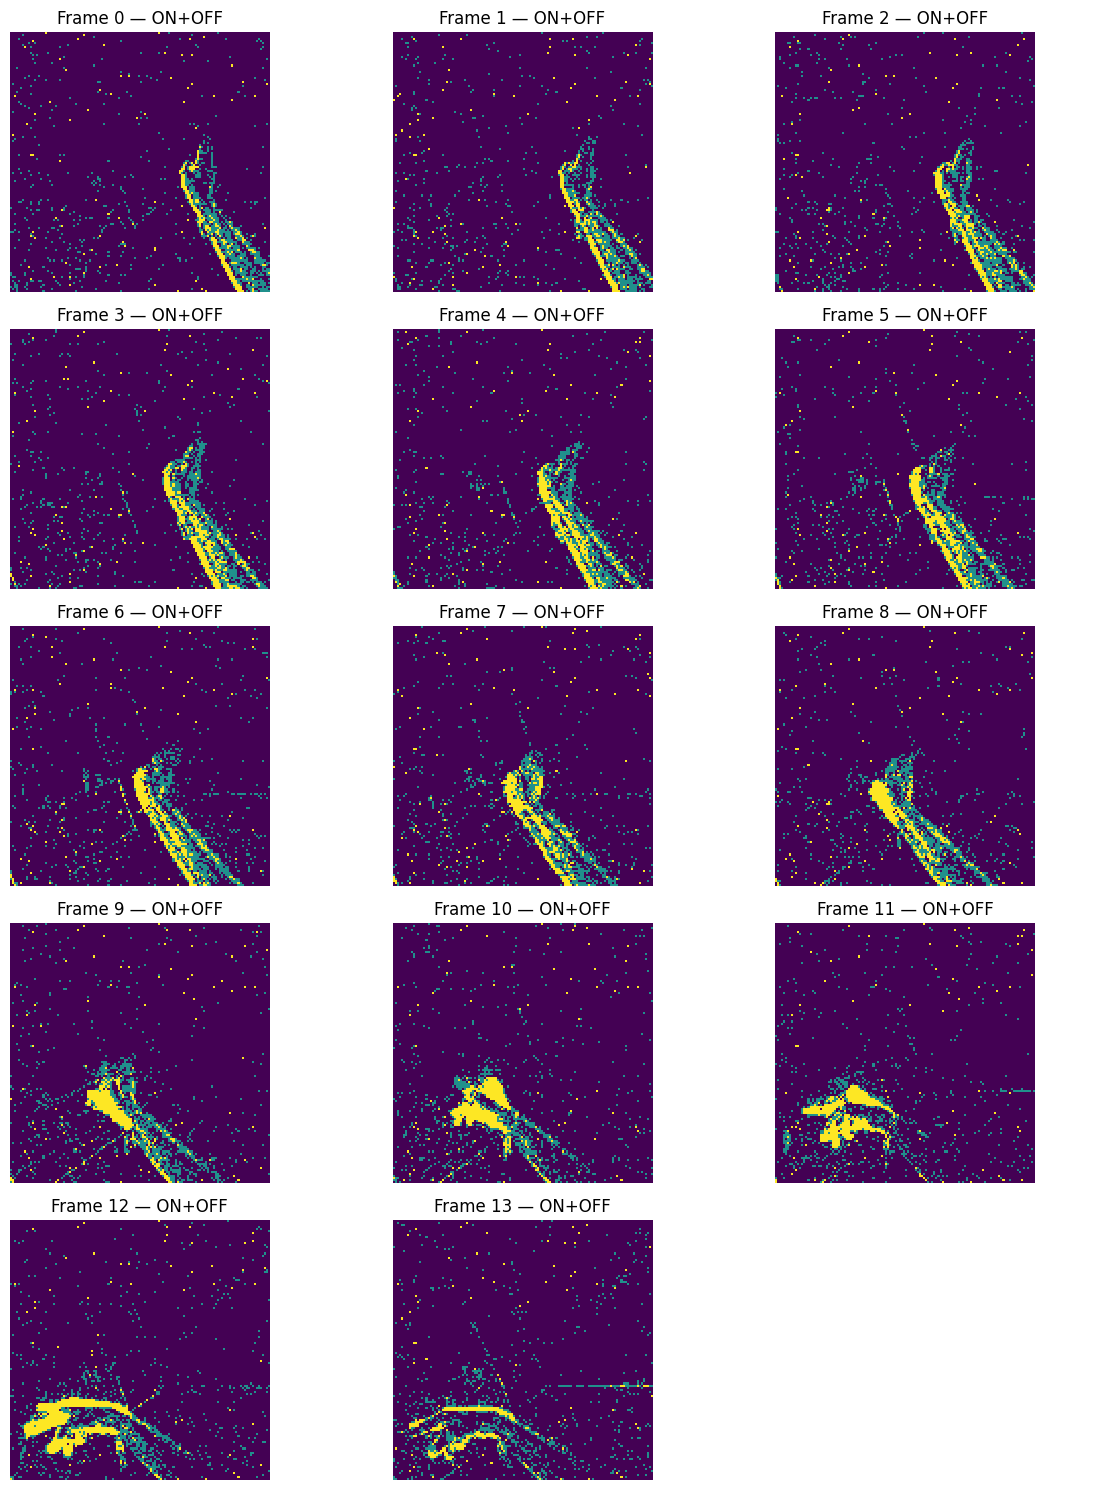

PREPROCESSED FRAME
dtype: float32
min: 0.0
max: 1.0
Frames: 14
Min (global):  0.0000
Max (global):  1.0000
Mean (avg):    0.0301


In [34]:
# -------------------------------
# Visualização ON + OFF (heatmap normalizado)
# -------------------------------
if len(frames_seq) == 0:
    print("Sem frames para visualizar.")
else:
    n_show = min(len(frames_seq), 14)
    rows, cols = 5, 3

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.reshape(rows, cols)

    for idx in range(rows * cols):
        r, c = divmod(idx, cols)
        ax = axes[r, c]

        if idx < n_show:
            frame = frames_seq[idx]      # (H, W, 2)
            on  = frame[..., 0]
            off = frame[..., 1]

            # Intensidade combinada (ON + OFF), normalizada
            intensity = np.clip(on + off, 0.0, 1.0)
            ax.imshow(
                intensity,
                vmin=0,
                vmax=1,
                cmap="viridis",
                interpolation="nearest",
            )
            ax.set_title(f"Frame {idx} — ON+OFF")
            ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# -------------------------------
# Sanity-check numérico (prova de normalização)
# -------------------------------
f = frames_seq[0]  # (H, W, 2)

print("PREPROCESSED FRAME")
print("dtype:", f.dtype)
print("min:", f.min())
print("max:", f.max())

# -------------------------------
# Estatísticas globais da sequência
# -------------------------------
mins = [f.min() for f in frames_seq]
maxs = [f.max() for f in frames_seq]
means = [f.mean() for f in frames_seq]

print(f"Frames: {len(frames_seq)}")
print(f"Min (global):  {min(mins):.4f}")
print(f"Max (global):  {max(maxs):.4f}")
print(f"Mean (avg):    {sum(means)/len(means):.4f}")

## 2º Bloco: Temporal Window (Δt) Builder:

Neste bloco pegamos numa sequência ordenada de F frames (já preprocessados no Bloco 1, cada um com shape (H, W, 2)) e construímos janelas temporais Δt com:
- K frames por janela (ex.: K=4)
- S stride (ajustável), por defeito S = K (janelas consecutivas)
- Sobreposição apenas na última janela, quando F não é múltiplo de K, para garantir que a última termina em F-1.

A saída será um tensor windows com shape (N, K, H, W, 2), onde N é o número de janelas geradas.

O número de janelas temporais geradas para um gesto é dado por:

$$
N_{\text{base}}=\left\lfloor\frac{F-K}{S}\right\rfloor+1
$$

onde:

- $F$ é o número total de frames do gesto (tamanho de `FramesSeq`);
- $K$ é um hiperparâmetro ajustável que define o número de frames por janela;
- $S$ é o stride da janela deslizante, também ajustável.

**Nota:** Se a última janela construída por esta fórmula não terminar em $F-1$, adiciona-se uma janela final alinhada ao fim do gesto (início em $F-K$), garantindo que o último frame é sempre incluído.

In [35]:
def build_temporal_windows(
    frames_seq: List[np.ndarray], 
    K: int = 4, 
    S: Optional[int] = None
) -> Tuple[np.ndarray, List[List[int]]]:

    if S is None:
        S = K

    F = len(frames_seq)

    if F == 0:
        raise ValueError("FramesSeq is empty (F=0).")
    if F < K:
        raise ValueError(f"Invalid: F ({F}) < K ({K}). This gesture is too short.")
    if K <= 0:
        raise ValueError("K must be > 0.")
    if S <= 0:
        raise ValueError("S must be > 0.")

    N_base = ((F - K) // S) + 1
    starts = [i * S for i in range(N_base)]

    indices: List[List[int]] = []
    for st in starts:
        indices.append(list(range(st, st + K)))

    last_end = indices[-1][-1]
    if last_end != F - 1:
        final_start = F - K
        final_idxs = list(range(final_start, final_start + K))
        if final_idxs != indices[-1]:
            indices.append(final_idxs)

    windows = np.stack(
        [np.stack([frames_seq[i] for i in idxs], axis=0) for idxs in indices],
        axis=0
    )

    return windows, indices

### Sanity-check: construir janelas e inspecionar índices

Confirmar:
- quantas janelas foram criadas
- quais os índices por janela (para validar a regra da última janela)
- shape final (N, K, H, W, 2)

In [36]:
K = 4
S = K  # por agora, como definimos

windows, win_indices = build_temporal_windows(frames_seq, K=K, S=S)

print("=== Temporal Window Builder Self-Check ===")
print(f"F (frames): {len(frames_seq)}")
print(f"K: {K}, S: {S}")
print(f"N (windows): {len(win_indices)}")
print("Window indices:")
for j, idxs in enumerate(win_indices):
    print(f"  Δt{j}: {idxs}")

print("windows shape:", windows.shape)  # (N, K, H, W, 2)
print("windows dtype:", windows.dtype)
print("windows min/max:", windows.min(), windows.max())

=== Temporal Window Builder Self-Check ===
F (frames): 14
K: 4, S: 4
N (windows): 4
Window indices:
  Δt0: [0, 1, 2, 3]
  Δt1: [4, 5, 6, 7]
  Δt2: [8, 9, 10, 11]
  Δt3: [10, 11, 12, 13]
windows shape: (4, 4, 128, 128, 2)
windows dtype: float32
windows min/max: 0.0 1.0


### Visualização de uma janela Δt (intensidade ON+OFF)

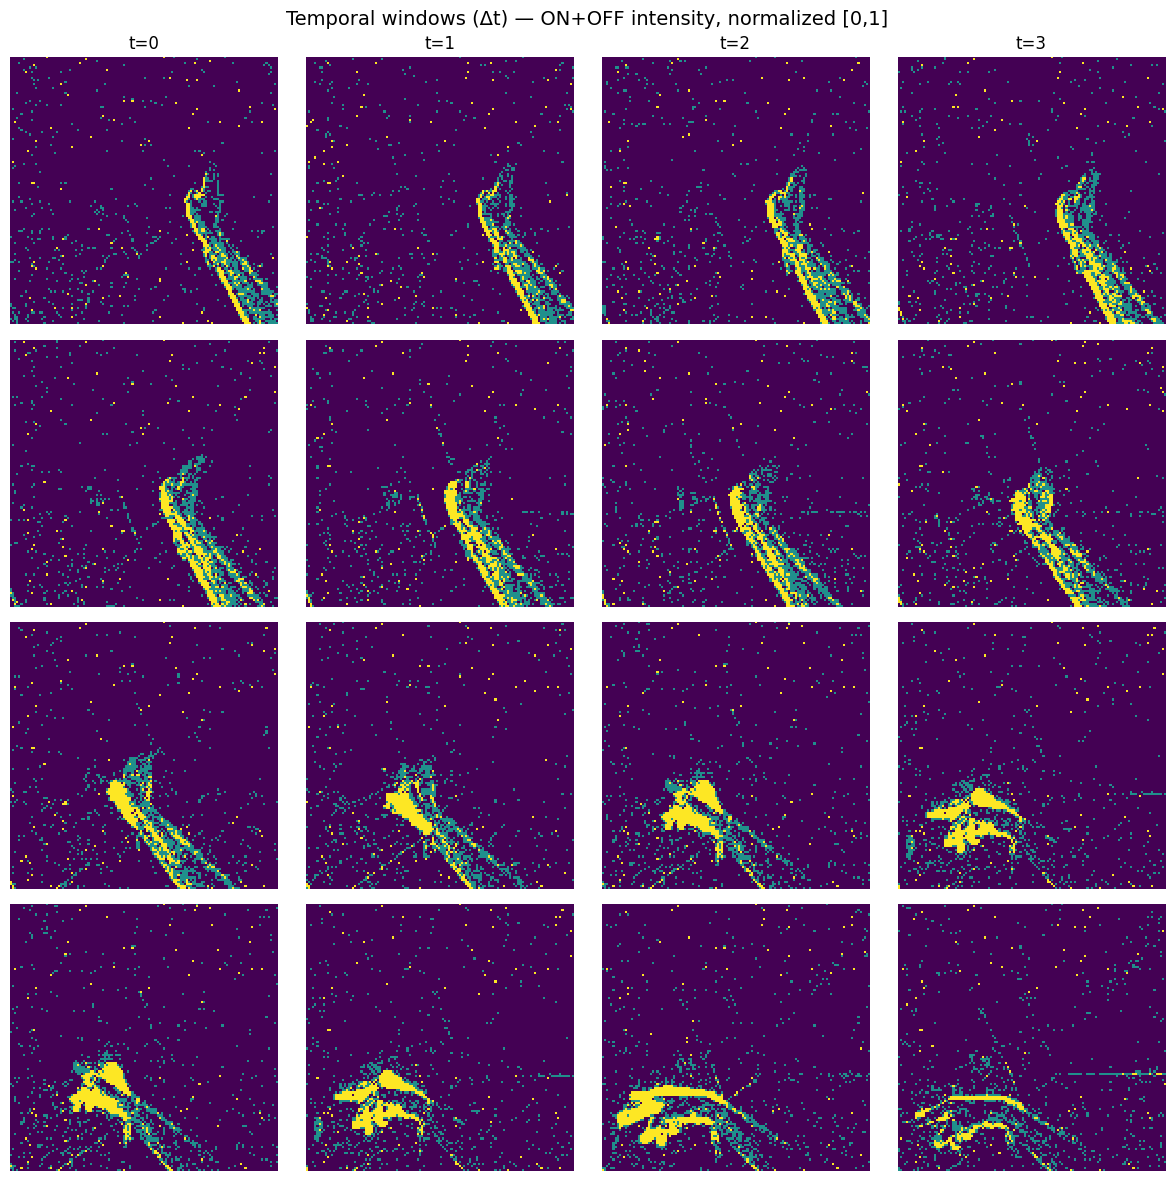

In [37]:
if windows.shape[0] == 0:
    print("Sem janelas para visualizar.")
else:
    N = windows.shape[0]   # nº de janelas (ex.: 4)
    K = windows.shape[1]   # frames por janela (ex.: 4)

    fig, axes = plt.subplots(N, K, figsize=(K * 3, N * 3))
    axes = np.atleast_2d(axes)

    for w in range(N):
        for t in range(K):
            ax = axes[w, t]
            frame = windows[w, t]      # (H, W, 2)

            on  = frame[..., 0]
            off = frame[..., 1]
            intensity = np.clip(on + off, 0.0, 1.0)

            ax.imshow(
                intensity,
                vmin=0,
                vmax=1,
                cmap="viridis",
                interpolation="nearest"
            )

            if w == 0:
                ax.set_title(f"t={t}")
            if t == 0:
                ax.set_ylabel(f"Δt{w}", rotation=0, labelpad=30)

            ax.axis("off")

    plt.suptitle("Temporal windows (Δt) — ON+OFF intensity, normalized [0,1]", fontsize=14)
    plt.tight_layout()
    plt.show()

## 3º Bloco: Adapted Event-Frame Builder

Neste bloco, o objetivo é: para cada janela temporal $\Delta t_k$ com $K$ frames, construímos $B = K - 1$ **bins** (fatias temporais), onde cada bin corresponde a uma transição entre dois frames consecutivos.

### Construção dos bins

- Bin $b$: transição $f_{b+1} \rightarrow f_b$

Por **polaridade**, definimos o tensor $F$ como:

$$
F[\ldots, b, 0] = \max\left(f^{ON}_{b+1} - f^{ON}_{b},\, 0\right)
$$

$$
F[\ldots, b, 1] = \max\left(f^{OFF}_{b+1} - f^{OFF}_{b},\, 0\right)
$$

onde:
- $f^{ON}_{b}$ é o canal **ON** (eventos positivos) do frame $f_b$;
- $f^{OFF}_{b}$ é o canal **OFF** (eventos negativos) do frame $f_b$;
- $\max(\cdot, 0)$ garante que apenas **ganhos** (incrementos) são mantidos.

O tensor resultante é:

$$
F \in \mathbb{R}^{H \times W \times B \times 2}
\quad \text{com} \quad B = K - 1
$$

### Log compression

Após gerar $F$, aplicamos compressão logarítmica (como no xR-EvT fazem, no bloco 4):

$$
F' = \ln(F + 1)
$$

### Saída

- Saída por janela: $(H, W, B, 2)$  
- Saída por gesto (todas as janelas): $(N, H, W, B, 2)$

In [38]:
def build_adapted_event_frames(
    windows: np.ndarray,  # (N, K, H, W, 2)
) -> np.ndarray:

    if windows.ndim != 5:
        raise ValueError(f"Expected windows with 5 dims (N,K,H,W,2). Got: {windows.shape}")
    if windows.shape[-1] != 2:
        raise ValueError(f"Expected last dim == 2 (ON/OFF). Got: {windows.shape[-1]}")

    N, K, H, W, C = windows.shape
    if K < 2:
        raise ValueError(f"K must be >= 2 to build B=K-1 bins. Got K={K}")

    B = K - 1

    # Split polarities: (N, K, H, W)
    on  = windows[..., 0]
    off = windows[..., 1]

    # Successive differences along time axis K -> (N, B, H, W)
    d_on  = np.diff(on, axis=1)
    d_off = np.diff(off, axis=1)

    # Keep only positive "gains"
    g_on  = np.maximum(d_on,  0.0)
    g_off = np.maximum(d_off, 0.0)

    # Pack into (N, B, H, W, 2) then reorder -> (N, H, W, B, 2)
    F = np.stack([g_on, g_off], axis=-1)  # (N, B, H, W, 2)
    F = np.transpose(F, (0, 2, 3, 1, 4))  # (N, H, W, B, 2)

    # IMPORTANT: no log here (faithful to xR-EvT activity test) I will do it after block 4
    return F.astype(np.float32)

In [39]:
event_frames = build_adapted_event_frames(windows)

print("=== Adapted Event-Frame Builder (PRE-LOG) Self-Check ===")
print("windows shape:", windows.shape)            # (N, K, H, W, 2)
print("event_frames shape:", event_frames.shape)  # (N, H, W, B, 2)
print("dtype:", event_frames.dtype)

# 1) Não-negatividade (obrigatório)
print("min:", event_frames.min())

# 2) Shape correto
N, K, H, W, _ = windows.shape
B = K - 1
expected_shape = (N, H, W, B, 2)
print("expected shape:", expected_shape)

# 3) Intervalo esperado dos valores (pré-log)
# Como os frames estão em [0,1] e usamos diferenças sucessivas + clamp:
# espera-se max <= 1
print("max (pre-log):", event_frames.max())

# 4) Check teórico do limite
print("expected max <= 1.0")

=== Adapted Event-Frame Builder (PRE-LOG) Self-Check ===
windows shape: (4, 4, 128, 128, 2)
event_frames shape: (4, 128, 128, 3, 2)
dtype: float32
min: 0.0
expected shape: (4, 128, 128, 3, 2)
max (pre-log): 1.0
expected max <= 1.0


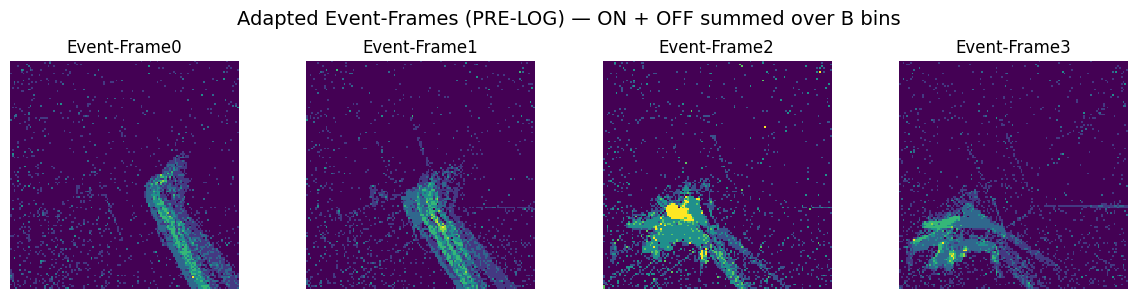

In [40]:
# event_frames shape: (N, H, W, B, 2)
N, H, W, B, _ = event_frames.shape

fig, axes = plt.subplots(1, N, figsize=(N * 3, 3))
axes = np.atleast_1d(axes)

for i in range(N):
    # ON + OFF somado ao longo dos bins
    intensity = event_frames[i].sum(axis=(2, 3))  # (H, W)

    axes[i].imshow(
        intensity,
        cmap="viridis",
        interpolation="nearest"
    )
    axes[i].set_title(f"Event-Frame{i}")
    axes[i].axis("off")

plt.suptitle(
    "Adapted Event-Frames (PRE-LOG) — ON + OFF summed over B bins",
    fontsize=14
)
plt.tight_layout()
plt.show()

## 4º Bloco – Activated Patch Extraction

Os **Event Frames 4D** de cada janela temporal, com shape **(H, W, B, 2)**,
são divididos em patches espaciais **não sobrepostos** de dimensão **P×P**,
preservando bins temporais e polaridades.

Cada patch tem forma **(P, P, B, 2)**.

Um patch é considerado **ativo** se contiver pelo menos uma percentagem
**$m$** de pixels ativos. Apenas patches ativos são mantidos.

Se o número de patches ativos for inferior ao limiar **$n$**, a janela
temporal $\Delta t$ é expandida para acumular mais eventos, repetindo-se o
processo até existirem, no mínimo, **$n$ patches ativos**.

A saída deste bloco é um conjunto de **$T$ patches ativos**, cada um com
forma **(P, P, B, 2)**, que seguem para o Transformer.

In [41]:
def activated_patch_extraction(
    event_frames_pre: np.ndarray,          # (N, H, W, B, 2)  raw, pre-log
    patch_size: int,                       # P
    min_activations_per_patch: float,      # m (0<m<=1) ou já convertido para int
    min_patches_per_chunk: Optional[int] = None,  # n_min (pode ser None/0)
    apply_log: bool = True,                # 'log' in preproc_polarity
) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    
    if event_frames_pre.ndim != 5:
        raise ValueError(f"Expected (N,H,W,B,2). Got {event_frames_pre.shape}")
    if event_frames_pre.shape[-1] != 2:
        raise ValueError("Last dim must be 2 (ON/OFF).")

    N, H, W, B, C = event_frames_pre.shape
    P = patch_size
    preproc_event_size = B * C  # bins * polarities

    if H % P != 0 or W % P != 0:
        raise ValueError(f"H and W must be multiples of P. Got H={H}, W={W}, P={P}")

    # Convert min_activations_per_patch:
    # If user passes m in (0,1], convert to int(m * P*P + 1) like xR-EvT
    if isinstance(min_activations_per_patch, float) and (0 < min_activations_per_patch <= 1):
        min_act = int(min_activations_per_patch * (P * P) + 1)
    else:
        min_act = int(min_activations_per_patch)

    patches_list: List[np.ndarray] = []
    centers_list: List[np.ndarray] = []

    # Precompute patch centers (same for every window)
    pixels_all = np.array([
        (i + P // 2, j + P // 2)
        for i in range(0, H, P)
        for j in range(0, W, P)
    ], dtype=np.int32)  # (num_patches, 2)

    for w in range(N):
        # chunk_candidate: (H, W, B, 2) -> reshape to (H, W, preproc_event_size)
        chunk_candidate = event_frames_pre[w].astype(float)  # (H,W,B,2)
        chunk_candidate = chunk_candidate.reshape(H, W, preproc_event_size)

        # patches: (H/P, W/P, P, P, preproc_event_size)
        polarity = view_as_blocks(chunk_candidate, (P, P, preproc_event_size))

        # inds (activity): count pixels with any nonzero across channels
        # faithful snippet:
        # inds = (polarity.sum(-1)!=0).reshape(..., P*P).sum(-1).reshape(num_patches) >= min_act
        inds = (polarity.sum(-1) != 0) \
            .reshape(polarity.shape[0], polarity.shape[1], P * P) \
            .sum(-1) \
            .reshape(polarity.shape[0] * polarity.shape[1]) >= min_act

        if inds.sum() == 0:
            continue
        if min_patches_per_chunk and inds.sum() < min_patches_per_chunk:
            continue

        # flatten all patches then select active
        polarity = polarity.reshape(
            polarity.shape[0] * polarity.shape[1],
            P * P * preproc_event_size
        )

        active_inds = np.where(inds)[0]
        polarity, pixels = polarity[active_inds], pixels_all[active_inds]

        # log compression after selection (faithful)
        if apply_log:
            polarity = np.log(polarity + 1.0).astype(np.float32)
        else:
            polarity = polarity.astype(np.float32)

        patches_list.append(polarity)
        centers_list.append(pixels)

    return patches_list, centers_list

### Sanity-check do Bloco 4

Foram usados os seguintes valores:

- P = 8 é patch_size
- m = 20% dos pixels do patch têm de estar ativos
- n = 5 é nr mínimo de patches ativos por janela

In [49]:
# hiperparâmetros
P = 8                  # patch_size
m = 0.20               # 20% dos pixels do patch têm de estar ativos
n_min = 5              # mínimo de patches ativos por janela

patches_list, centers_list = activated_patch_extraction(
    event_frames_pre=F_pre,                  
    patch_size=P,
    min_activations_per_patch=m,
    min_patches_per_chunk=n_min,
    apply_log=True,
)

print("=== Activated Patch Extraction Self-Check ===")
print(f"Total windows input (N): {F_pre.shape[0]}")
print(f"Windows accepted: {len(patches_list)}")

if len(patches_list) > 0:
    patches0 = patches_list[0]
    centers0 = centers_list[0]

    print("Example window:")
    print("  patches shape:", patches0.shape)   # (T, P*P*B*2)
    print("  centers shape:", centers0.shape)   # (T, 2)
    print("  T (active patches):", patches0.shape[0])

    print("  patches dtype:", patches0.dtype)
    print("  patches min/max:", patches0.min(), patches0.max())

=== Activated Patch Extraction Self-Check ===
Total windows input (N): 4
Windows accepted: 4
Example window:
  patches shape: (44, 384)
  centers shape: (44, 2)
  T (active patches): 44
  patches dtype: float32
  patches min/max: 0.0 0.6931472


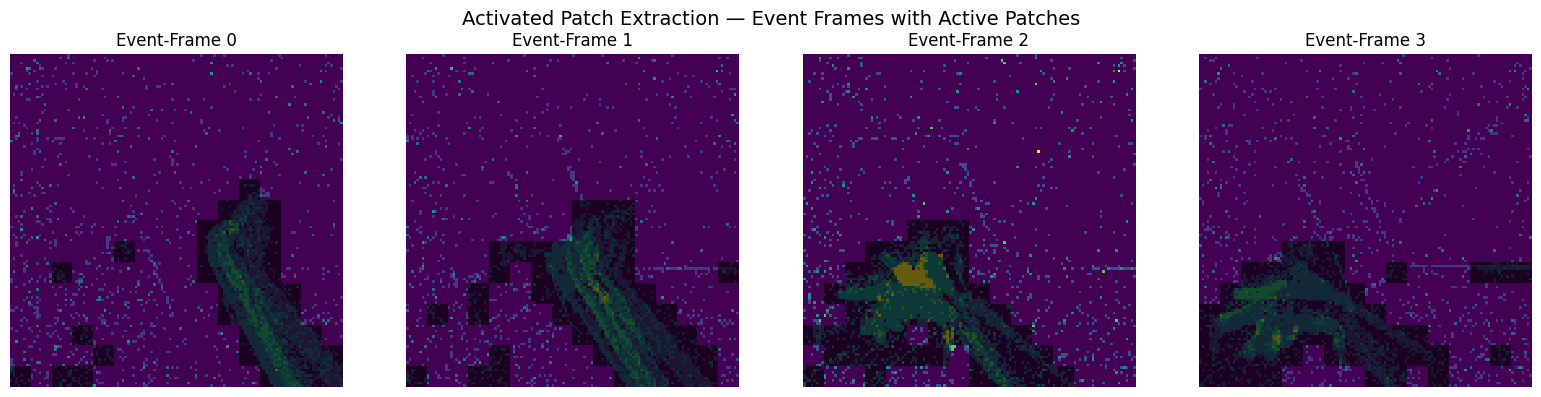

In [48]:
# Número de janelas a mostrar (aqui queremos as 4)
N_show = len(event_frames)
P = 8  # patch size (tem de ser o mesmo usado na extração)

fig, axes = plt.subplots(1, N_show, figsize=(4 * N_show, 4))
axes = np.atleast_1d(axes)

for w in range(N_show):
    ax = axes[w]

    # Event-frame pré-log: (H, W, B, 2)
    frame = event_frames[w]

    # Intensidade total (ON + OFF, somado nos bins)
    intensity = frame.sum(axis=(2, 3))  # (H, W)

    H, W = intensity.shape

    # Construir máscara de patches ativos
    active_centers = centers_list[w]   # (T, 2)
    active_mask = np.zeros((H, W), dtype=bool)

    half = P // 2
    for (y, x) in active_centers:
        active_mask[y-half:y+half, x-half:x+half] = True

    # Plot
    ax.imshow(intensity, cmap="viridis", interpolation="nearest")
    ax.imshow(
        np.ma.masked_where(~active_mask, active_mask),
        cmap="gray",
        alpha=0.6,
        interpolation="nearest"
    )

    ax.set_title(f"Event-Frame {w}")
    ax.axis("off")

plt.suptitle(
    "Activated Patch Extraction — Event Frames with Active Patches",
    fontsize=14
)
plt.tight_layout()
plt.show()